HPCA(WT) vs. HPCA(N75K)
=======================

In [1]:
import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io

from scipy import ndimage
from scipy import signal
from scipy import stats


from domb.reg_type.wf_x2_m2 import WF_2x_2m as WF
from domb.fret.e_app import Eapp
from domb.red_green.wt_vs_mut import WTvsMut as WvM
from domb.utils import plot
from domb.utils.plot import CMaps
from domb.utils import masking

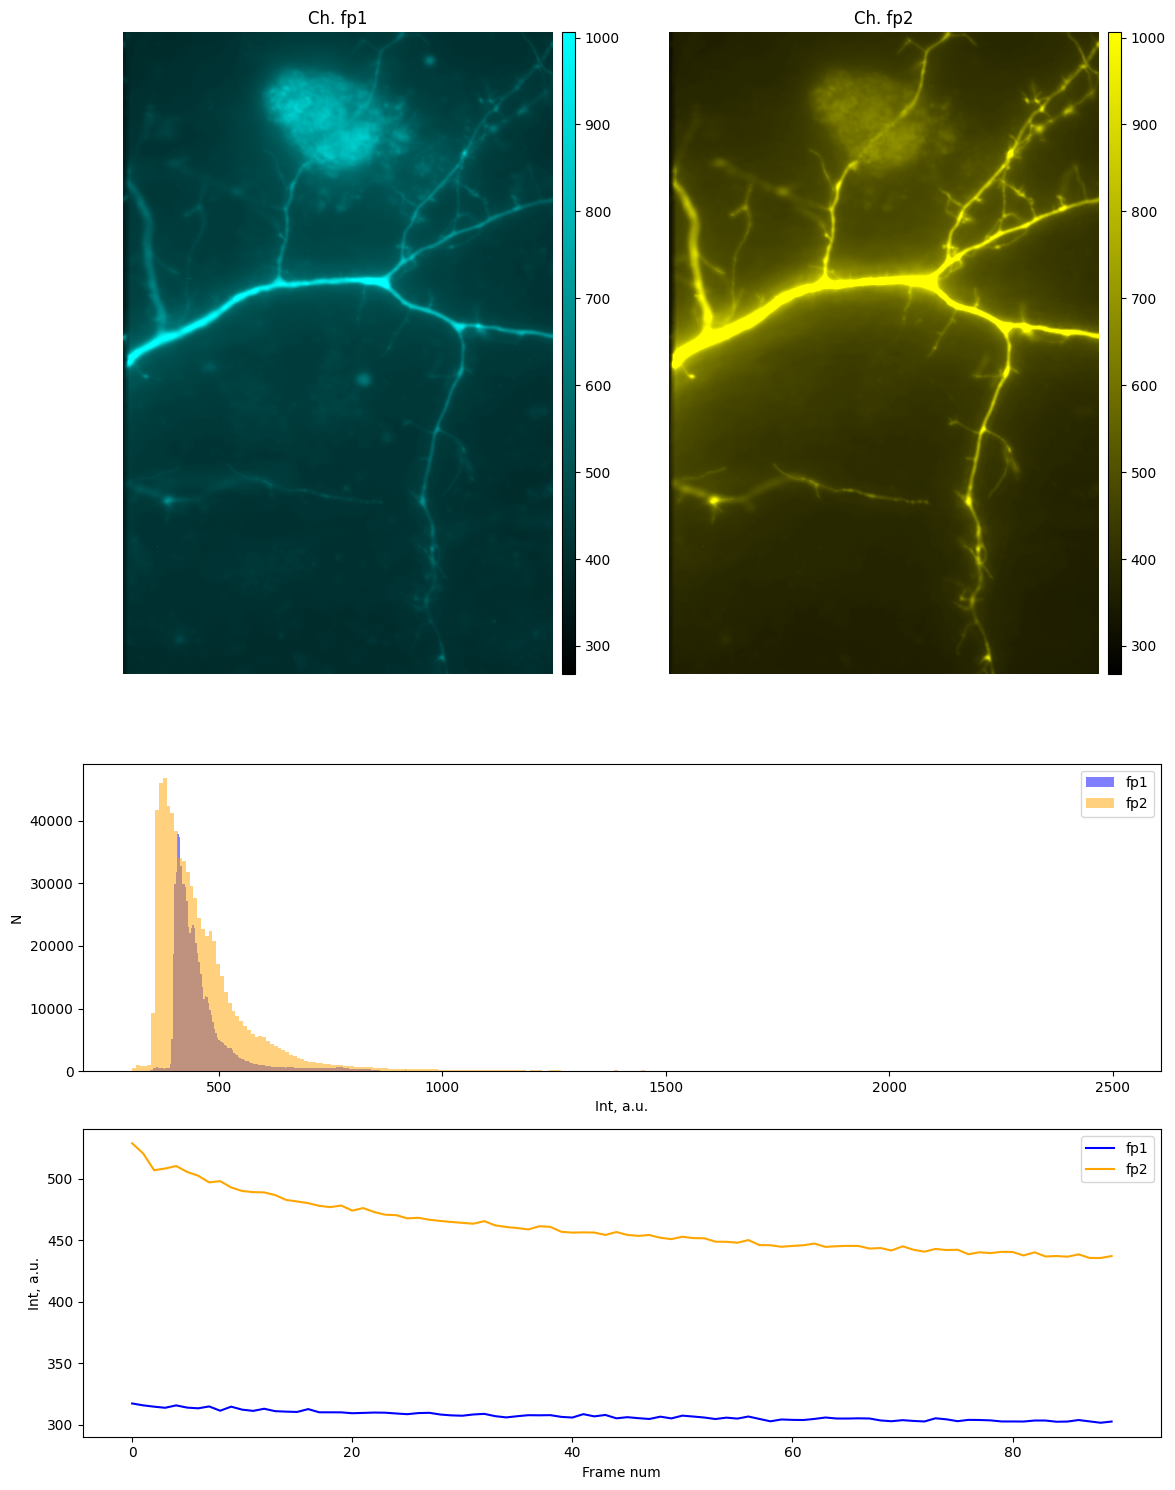

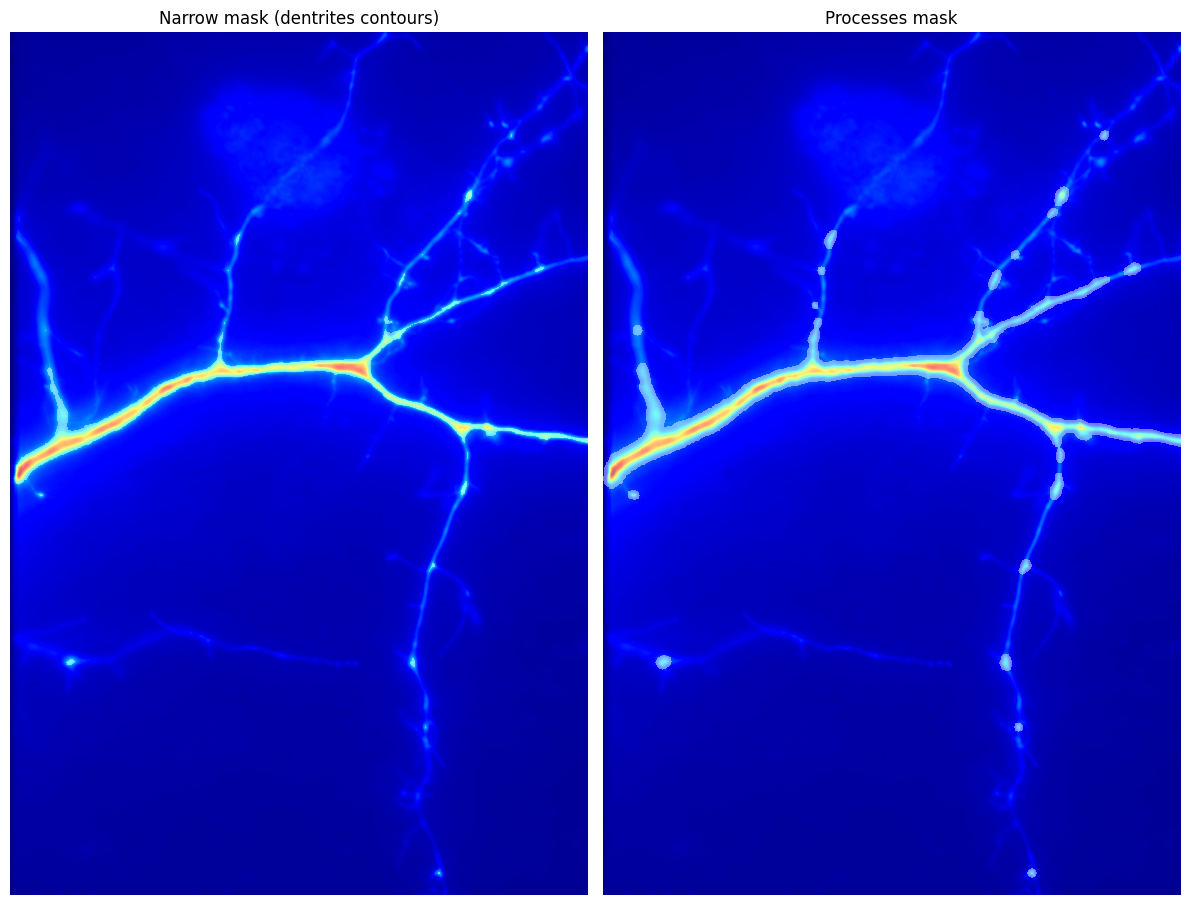

In [2]:
reg_path = 'data/wt_vs_mut/23_06_06_04.tif'
reg_name = reg_path.split('/')[-1]
reg_name = reg_name.split('.')[0]


# fp1 - CFP, fp2 - YFP
reg = WF(img_path=reg_path, img_name=reg_name, ch_order={'fp1':3,'fp2':1}, wf_sigma=.5,
         soma_mask=False, soma_th=.9, soma_ext=200, proc_sigma=.5)  # processes masking parameters

reg.ch_pic()
reg.processes_mask_pic()

## RG

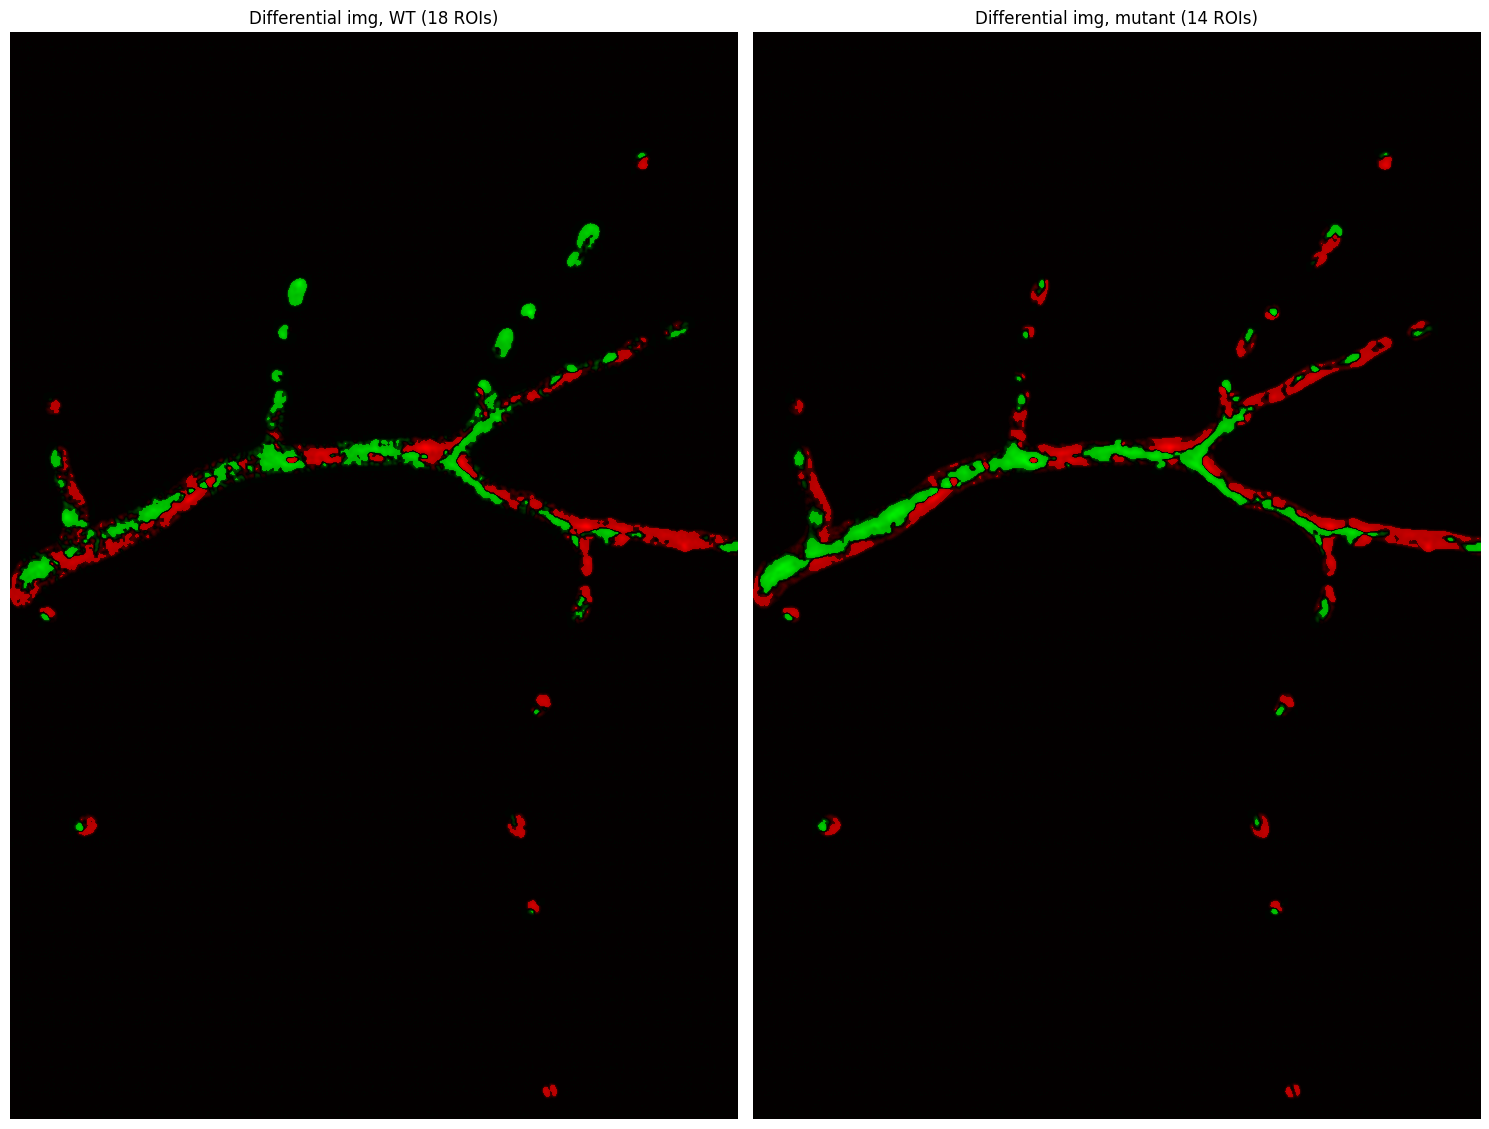

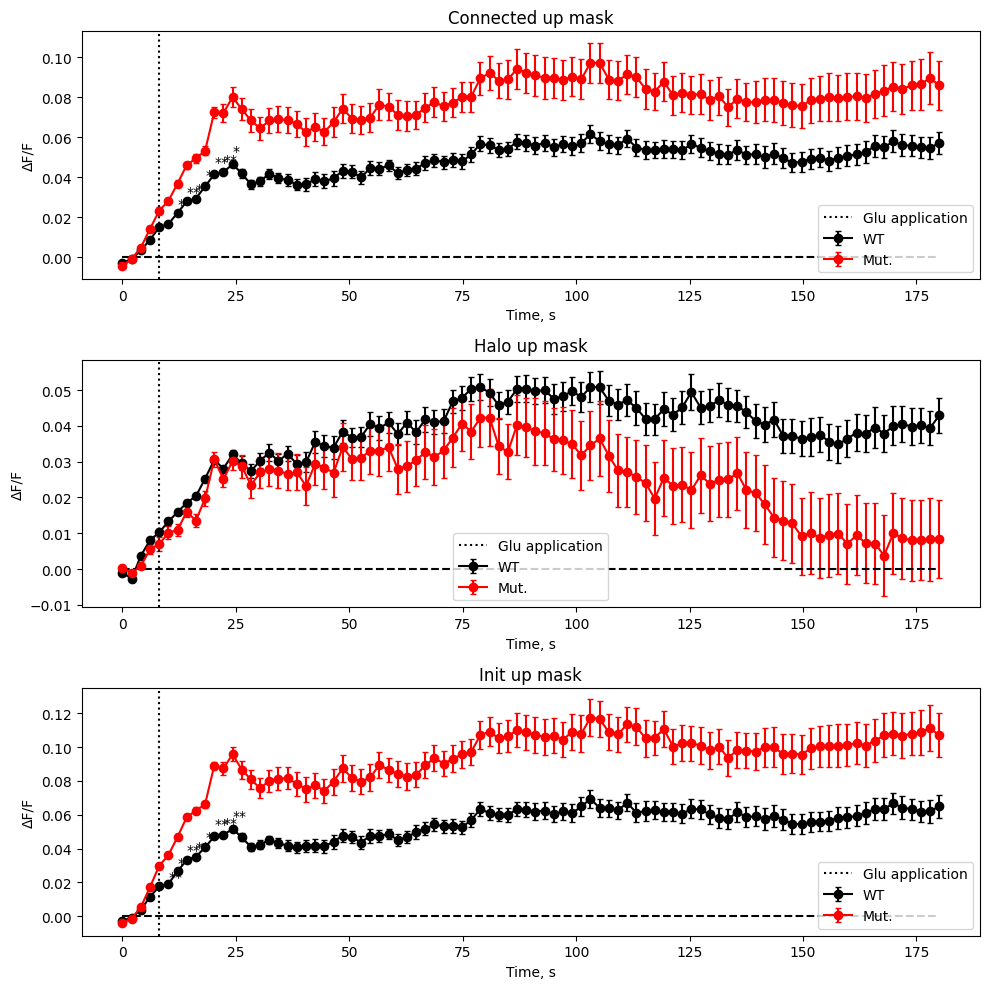

In [3]:
reg_RG = WvM(wt_img=reg.corr_fp1_img,
             mut_img=reg.corr_fp2_img,
             narrow_proc_mask=reg.narrow_proc_mask,
             proc_mask=reg.proc_mask,
             sd_tolerance=1.5, base_frames=3, stim_start=8, stim_win=5)  # up mask calc parameters

reg_RG.diff_img_pic()
reg_RG.df_mean_prof_pic()

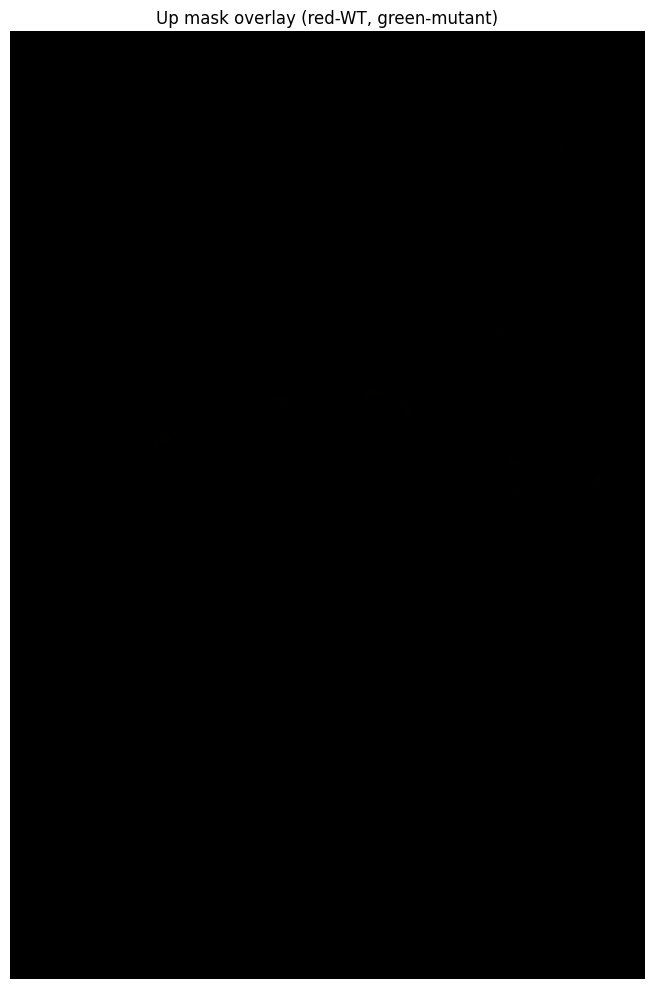

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(plot.toRGB(reg_RG.wt_up_mask, reg_RG.mut_up_mask, np.zeros_like(reg_RG.wt_up_mask)))
plt.axis('off')
plt.title('Up mask overlay (red-WT, green-mutant)')
plt.tight_layout()
plt.show()

/tmp/ipykernel_5714/1112733209.py:35: RuntimeWarning: invalid value encountered in divide
  b_norm_img = (b_img - np.min(b_img)) / (np.max(b_img) - np.min(b_img)).astype(np.uint8)


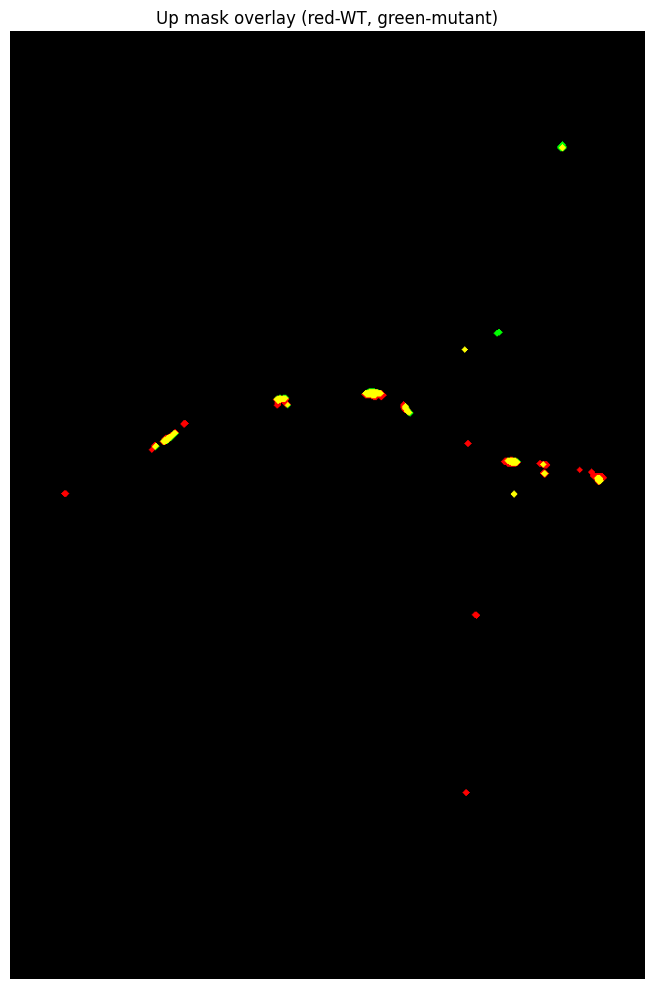

In [12]:
import warnings

def toRGB(r_img:np.ndarray, g_img:np.ndarray, b_img:np.ndarray):
    """ Convert three 2d arrays to RGB (input arrays must have same size).

    Parameters
    ----------
    r_img: ndarray [x,y]
        2D array for red chennel
    g_img: ndarray [x,y]
        2D array for green chennel
    b_img: ndarray [x,y]
        2D array for blue chennel

    Returns
    -------
    rgb_img: ndarray [x,y]
        RGB image

    """
    warnings.filterwarnings('error')
    r_img = np.asarray(r_img, dtype='uint8')
    try:
        r_norm_img = (r_img - np.min(r_img)) / (np.max(r_img) - np.min(r_img)).astype(np.uint8)
    except RuntimeWarning:
        r_norm_img = r_img

    g_img = np.asarray(g_img, dtype='uint8')
    try:
        g_norm_img = (g_img - np.min(g_img)) / (np.max(g_img) - np.min(g_img)).astype(np.uint8)
    except RuntimeWarning:
        g_norm_img = g_img

    b_img = np.asarray(b_img, dtype='uint8')
    try:
        b_norm_img = (b_img - np.min(b_img)) / (np.max(b_img) - np.min(b_img)).astype(np.uint8)
    except warnings.simplefilter("error", RuntimeWarning):
        b_norm_img = b_img
    

    rgb_img = np.stack([r_norm_img, g_norm_img, b_norm_img], axis=-1) 
    return rgb_img


plt.figure(figsize=(10,10))
plt.imshow(toRGB(reg_RG.wt_up_mask, reg_RG.mut_up_mask, np.zeros_like(reg_RG.wt_up_mask)))
plt.axis('off')
plt.title('Up mask overlay (red-WT, green-mutant)')
plt.tight_layout()
plt.show()

In [ ]:
plot.stat_line_plot(arr_list=[reg_RG.wt_conn_df_arr,
                              reg_RG.mut_conn_df_arr],
                    lab_list=['WT', 'N75K'],
                    stat_method='ci',
                    stim_t=8,
                    figsize=(10,4))

## FRET

In [ ]:
a=0.1489
b=0.1324
c=0.2481
d=0.8525
abcd = [a, b, c, d]

G = 6.117

reg_FRET = Eapp(dd_img=reg.ch0_img,
                da_img=reg.ch1_img,
                ad_img=reg.ch2_img,
                aa_img=reg.ch3_img,
                abcd_list=abcd, G_val=G,
                mask=reg.proc_mask, corr_by_mask=True)  # parameters for E_corr_calc

_,conn_fret = masking.label_prof_arr(input_label=reg_RG.connected_up_label,
                                   input_img_series=reg_FRET.Ecorr_img)
_,halo_fret = masking.label_prof_arr(input_label=reg_RG.halo_up_label, 
                                   input_img_series=reg_FRET.Ecorr_img)
_,init_fret = masking.label_prof_arr(input_label=reg_RG.init_up_label,
                                   input_img_series=reg_FRET.Ecorr_img)

plot.stat_line_plot(arr_list=[conn_fret,
                              halo_fret,
                              init_fret],
                    lab_list=['conn', 'halo', 'init'],
                    stat_method='ci',
                    figsize=(10,4))

In [ ]:
FRET_frame = reg_FRET.Ecorr_img[0]

plt.figure(figsize=(10,10))
plt.imshow(FRET_frame,
           cmap='viridis',  # plot.CMaps().cmap_red_green,
           vmin=-np.max(np.abs(FRET_frame)), vmax=np.max(np.abs(FRET_frame)))

## dF vs. FRET

In [ ]:
arr_se_stat = lambda x: (np.mean(x, axis=0), \
                         np.std(x, axis=0)/np.sqrt(x.shape[1]))

wt_mean, wt_var = arr_se_stat(reg_RG.wt_conn_df_arr) 
mut_mean, mut_var = arr_se_stat(reg_RG.mut_conn_df_arr)

fret_mean, fret_var = arr_se_stat(halo_fret)


time_line = np.linspace(0, wt_mean.shape[0]*2, \
                            num=wt_mean.shape[0])

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.errorbar(time_line, wt_mean,
             yerr = wt_var,
             fmt ='-o', color='k', capsize=4, label='WT')
ax1.errorbar(time_line, mut_mean,
             yerr = mut_var,
             fmt ='-o', color='r', capsize=4, label='N75K')
ax1.set_xlabel('Time, s')
ax1.set_ylabel('ΔF/F', color='r')
ax1.tick_params(axis ='y', labelcolor='r')
ax1.hlines(y=0, xmin=0, xmax=time_line.max(), linestyles='--', color='k')
ax1.axvline(x=10, color='k', linestyle=':', label='Glu application')

plt.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.errorbar(time_line, fret_mean*100,
             yerr = fret_var*100,
             fmt ='-o', color='b', capsize=4, label='FRET')
ax2.set_ylim([np.mean(np.concatenate((wt_mean, mut_mean))),50])
ax2.set_ylabel('E app, %', color='b')
ax2.tick_params(axis ='y', labelcolor='b')

plt.legend(loc='lower left')
plt.tight_layout()
plt.title('Connected')
plt.show()